<a href="https://colab.research.google.com/github/chrishamblin7/feature_inhibition/blob/main/feature_inhibition_demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup 

(uncomment and run below code if on colab, and you need to set up environment)

In [ ]:
!pip install faccent==1.0

### config variables

In [2]:
#Do you have a gpu?
#DEVICE = 'cpu'
DEVICE = 'cuda:0'

#some of these analyses will require a dataset, but we'll front load these demos with those that don't.
#If you have imagenet validation set on your machine, put the path below.
IMAGENET_PATH = '' 



In [3]:
#model
from faccent.modelzoo import inceptionv1, inceptionv1_decomposed

model = inceptionv1_decomposed(pretrained=True, redirected_ReLU=False)
_ = model.to(DEVICE).eval()
#convert_relu_layers(model) #make relus not 'inplace'
MODEL_INPUT_SIZE = model.model_input_size
MODEL_INPUT_RANGE = model.model_input_range

/mnt/data/chris/dropbox/Research-Hamblin/Projects/faccent/env/lib/python3.7/site-packages/torch/cuda/__init__.py:132: UserWarning: 
    Found GPU3 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


### +/- Image Accentuations and Inversions

In [4]:
#target unit

unit = 379
target_layer = 'mixed3b_pre_relu'
cam_layer = 'mixed3a'

no image specified, so intializing with random phase, and magnitude from "clean_decorrelated.npy"


 99%|█████████▉| 100/101 [00:05<00:00, 21.36it/s]

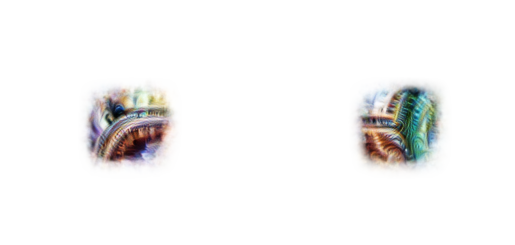

100%|██████████| 101/101 [00:05<00:00, 18.94it/s]


In [5]:
#regular feature visualization

from faccent import param, transform, render, objectives


out_thresholds = [100]
inline_thresholds = [100]

img_size = (224,224)
canvas_size = (512,512)

trans_p = 8


obj1 = objectives.neuron(target_layer,unit, batch=0)
obj2 = -objectives.neuron(target_layer,unit, batch=1)
obj = obj1+obj2


parameterizer = param.fourier_phase(device=DEVICE,
                                    img_size = canvas_size,
                                    batch_size = 2)

transforms = [transform.box_crop(box_min_size=0.9,
                                     box_max_size=0.99,
                                     box_loc_std=0.05,
                    ),
            transform.uniform_gaussian_noise()
                 ]


imgs, img_trs, _, _ = render.render_vis(model,
                                        obj,
                                        parameterizer = parameterizer,
                                        transforms = transforms,
                                        out_thresholds = out_thresholds,
                                        inline_thresholds = inline_thresholds,
                                        trans_p= trans_p,
                                        nb_transforms = 8) 





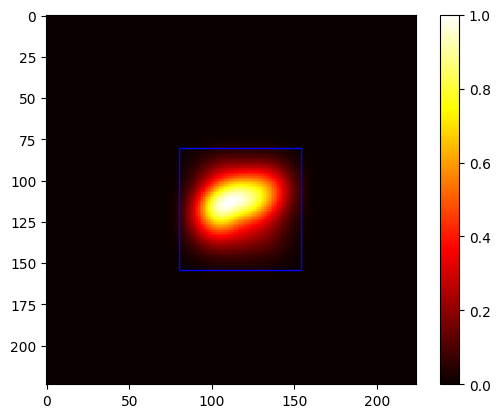

In [6]:
#get central unit receptive field
from faccent.cam import gradient_based_receptive_field, find_crop_bounds,plot_recep_field_and_crop_bounds
import torch
import torch.nn.functional as F


recep_field, target_crop_bounds = gradient_based_receptive_field(model,target_layer,
                                   position='middle',
                                   unit = unit,
                                   input_size = MODEL_INPUT_SIZE,
                                   input_range=MODEL_INPUT_RANGE,
                                   device=DEVICE,
                                   integrate = True,
                                   init_img = None,
                                   crop_threshold = .05,
                                   square = True,
                                   plot = True)


canvas_size = (512,512)
recep_field_tr = torch.tensor(recep_field).repeat(3, 1, 1)  # This repeats the tensor along a new dimension
recep_field_tr = F.interpolate(recep_field_tr.unsqueeze(0), size=canvas_size, mode='bilinear', align_corners=False)
recep_field_tr = recep_field_tr.squeeze(0)


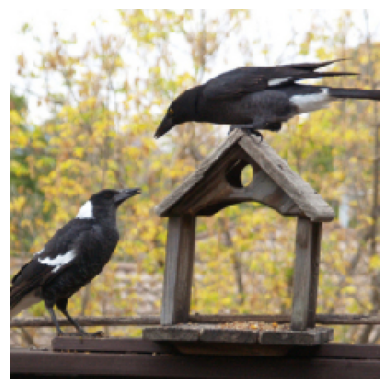

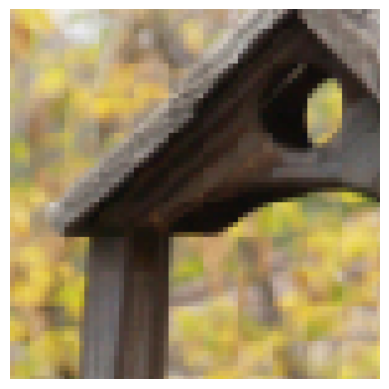

In [7]:
# tense visualization
#setup


from faccent import param, transform, render, objectives
from faccent.utils import images_to_video, scale_crop_bounds, show, plot_alpha, save_png_image_with_transparency
import numpy as np
from faccent.utils import img_to_img_tensor


img_path = 'test_images/tense_curve_1.jpg'

out_thresholds = [5,10,20,40,60,100,120]
inline_thresholds = range(0,80,20)
trans_p_range = np.logspace(np.log2(4), np.log2(3), num=51, base=2, endpoint=True, dtype=None, axis=0)
blur_range = np.logspace(np.log2(4), np.log2(2), num=51, endpoint=True, base=2, dtype=None, axis=0)

trans_p = 3

rl = torch.nn.ReLU(inplace = False)

optimizer = lambda params: torch.optim.Adam(params, lr=.02)

img_size = (224,224)
canvas_size = (512,512)
crop_buffer=40
relu_act = False
cosine_power = 1.0


#show crop
img= img_to_img_tensor(img_path,size = img_size)
img_crop = img[:,:,target_crop_bounds[0][0]:target_crop_bounds[0][1],target_crop_bounds[1][0]:target_crop_bounds[1][1]]
img_crop = F.interpolate(img_crop, size=img_size)

show(img, normalize = False)
show(img_crop, normalize = False)


In [8]:
from faccent.utils import default_model_input_range, default_model_input_size, TargetReached, img_to_img_tensor, LargestCenterCrop, image_data
from faccent.transform import range_normalize
from torchvision.transforms import Compose,Resize,ToTensor
from PIL import Image

transforms = []
transforms.append(LargestCenterCrop())
transforms.append(Resize(MODEL_INPUT_SIZE))
transforms.append(ToTensor())
transforms.append(range_normalize(MODEL_INPUT_RANGE))
preprocess = Compose(transforms)

img = preprocess(Image.open(img_path))

In [9]:
#get attribution vector
from faccent.utils import default_model_input_range, default_model_input_size, TargetReached, img_to_img_tensor, LargestCenterCrop, image_data
from faccent.cam import layer_saver, actgrad_extractor


position = 'middle'                                                          
num_workers = 2


transforms = []
transforms.append(LargestCenterCrop())
transforms.append(Resize(MODEL_INPUT_SIZE))
transforms.append(ToTensor())
transforms.append(range_normalize(MODEL_INPUT_RANGE))
preprocess = Compose(transforms)



img = preprocess(Image.open(img_path))
img_batch = img.unsqueeze(dim=0).to(DEVICE)

#get attribution vector
with layer_saver(model, target_layer, detach=False) as target_saver:
    with actgrad_extractor(model, [cam_layer], concat=False) as score_saver:

        model.requires_grad_(True)
        model.zero_grad()

        batch_target_activations = target_saver(img_batch)[target_layer]
        if position == 'middle':
            batch_target_activations = batch_target_activations[:,:,batch_target_activations.shape[2]//2,batch_target_activations.shape[3]//2]
        elif position is not None:
            batch_target_activations = batch_target_activations[:,:,position[0],position[1]]

        batch_unit_act = batch_target_activations[:,unit]


        loss = torch.sum(batch_unit_act)
        loss.backward()

        activations = score_saver.activations
        gradients = score_saver.gradients
        
        
actgrads = activations[cam_layer]*gradients[cam_layer]


from faccent.cam import find_crop_bounds

act_crop_bounds = find_crop_bounds(torch.abs(actgrads).sum(dim=(0,1)),0.01)
act_crop_bounds

[[12, 17], [12, 17]]

  0%|          | 0/121 [00:00<?, ?it/s]

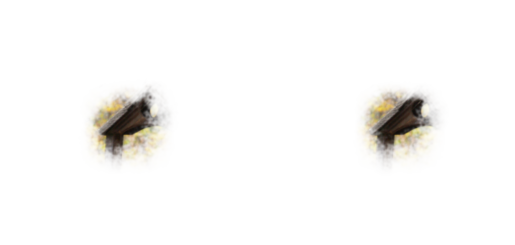

 16%|█▌        | 19/121 [00:01<00:07, 13.17it/s]

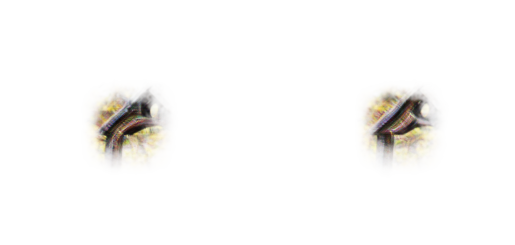

 32%|███▏      | 39/121 [00:03<00:06, 13.17it/s]

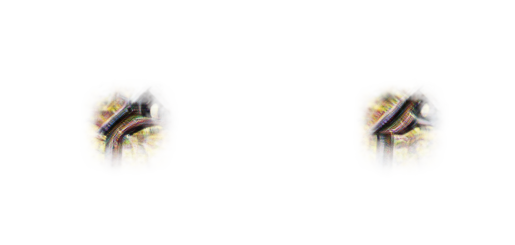

 49%|████▉     | 59/121 [00:04<00:04, 13.16it/s]

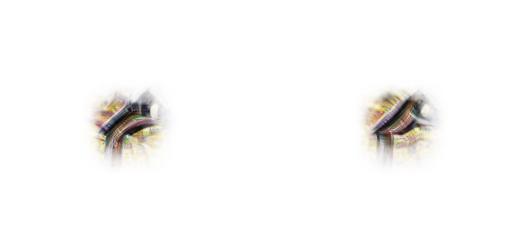

 98%|█████████▊| 119/121 [00:09<00:00, 13.49it/s]

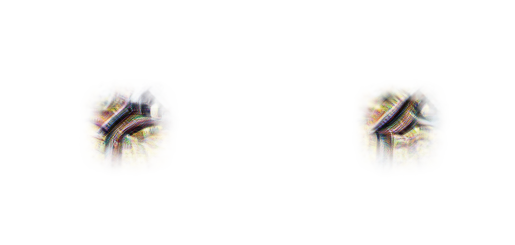

100%|██████████| 121/121 [00:09<00:00, 12.18it/s]


In [10]:
#accentuation

img_i = 0 #only one image

obj1 = objectives.spatial_channel_cosim(cam_layer,
                             rl(actgrads[img_i]),
                             relu_act=relu_act, 
                             cosine_power = cosine_power,
                             crop_bounds = act_crop_bounds,
                             batch=0)
#negative objective
obj2 = objectives.spatial_channel_cosim(cam_layer,
                             rl(-actgrads[img_i]),
                             relu_act=relu_act,
                             cosine_power = cosine_power,
                             crop_bounds = act_crop_bounds,
                             batch=1)


obj = obj1 + obj2

parameterizer = param.fourier_phase(init_img = img_path,
                                    device=DEVICE,
                                    img_size = canvas_size,
                                    batch_size = 2
                                    )

transforms = [transform.box_crop(box_min_size=0.9,
                                     box_max_size=0.99,
                                     box_loc_std=0.05,
                    ),
            transform.uniform_gaussian_noise()
                 ]

#transforms = transform.standard_jitter_transforms


imgs, img_trs, _, _ = render.render_vis(model,
                                        obj,
                                        parameterizer = parameterizer,
                                        transforms = transforms,
                                        optimizer = optimizer,
                                        #img_tr_obj = obj1,
                                        img_size = canvas_size,
                                        out_thresholds = out_thresholds,
                                        inline_thresholds = inline_thresholds,
                                        trans_p= trans_p)




no image specified, so intializing with random phase, and magnitude from "clean_decorrelated.npy"


  0%|          | 0/121 [00:00<?, ?it/s]

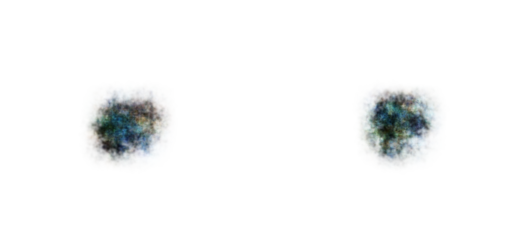

 16%|█▌        | 19/121 [00:01<00:07, 13.70it/s]

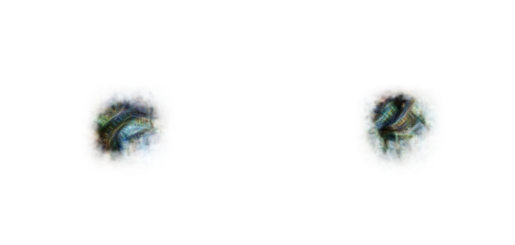

 32%|███▏      | 39/121 [00:03<00:06, 13.32it/s]

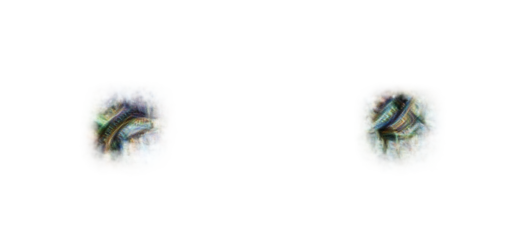

 49%|████▉     | 59/121 [00:04<00:04, 13.23it/s]

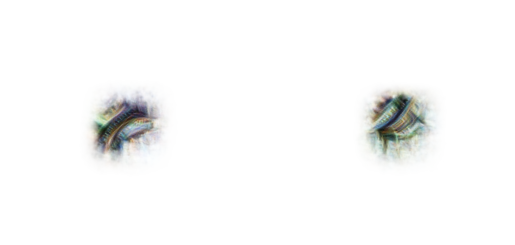

 98%|█████████▊| 119/121 [00:09<00:00, 13.38it/s]

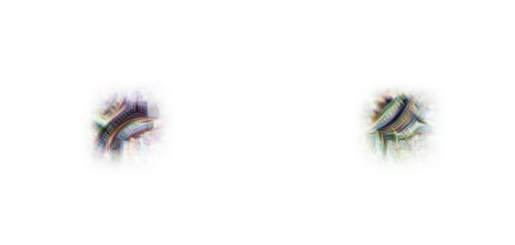

100%|██████████| 121/121 [00:09<00:00, 12.29it/s]


In [12]:
#+/- inversion

#everything is the same, just dont specify an init_image
parameterizer = param.fourier_phase(
                                    device=DEVICE,
                                    img_size = canvas_size,
                                    batch_size = 2
                                    )



imgs, img_trs, _, _ = render.render_vis(model,
                                        obj,
                                        parameterizer = parameterizer,
                                        transforms = transforms,
                                        optimizer = optimizer,
                                        img_size = canvas_size,
                                        out_thresholds = out_thresholds,
                                        inline_thresholds = inline_thresholds,
                                        trans_p= trans_p)


